In [1]:
import time
import inspect
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import preprocess, features, classifier, metrics, logging

In [2]:
seed = 42
np.random.seed(seed)

models_path = 'models'  # folder of models
log_path = 'log'  # folder of log.csv
logger = logging.Logger(log_path)  # init logger to log.csv
# logger.init_log()

In [3]:
def load_datasets():
    test1_path = 'data/test1.wtag'
    train1_path = 'data/train1.wtag'
    train2_path = 'data/train2.wtag'
    comp1_path = 'data/comp1_tagged.words'  # need to tag dataset to use
    comp2_path = 'data/comp2_tagged.words'  # need to tag dataset to use

    train_dataset = preprocess.Dataset(train1_path)
#     train_dataset = preprocess.Dataset(train2_path)
    val_dataset = preprocess.Dataset(test1_path)
#     val_dataset = preprocess.Dataset(comp1_path)
#     val_dataset = preprocess.Dataset(comp2_path)
    return train_dataset, val_dataset

def comp_dataset(tags):
    comp1_path = 'data/comp1.words'
    comp2_path = 'data/comp2.words'
    
    comp_dataset = preprocess.Dataset(comp1_path, labeled=False, tags=tags)
#     comp_dataset = preprocess.Dataset(comp2_path, labeled=False, tags=tags)
    return comp_dataset

train_dataset, val_dataset = load_datasets()
# comp_dataset = comp_dataset(train_dataset.tags)

In [4]:
def create_feats(prints=True):
    group_thresholds = {
        # -------------------------------- feature --------------------- | -- Threshold --
        lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,     # mandatory feature f100
        lambda t2, t1, w, i, t: tuple([w[i][-4:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-3:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-2:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-1:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][:4].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:3].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:2].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:1].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([t2, t1, t]):                               1,     # mandatory feature f103
        lambda t2, t1, w, i, t: tuple([t1, t]):                                   1,     # mandatory feature f104
        lambda t2, t1, w, i, t: tuple([t]):                                       1,     # mandatory feature f105
        lambda t2, t1, w, i, t: tuple([w[i].islower(), t]):                       1,     # mandatory feature has_uppercase
        lambda t2, t1, w, i, t: tuple([any(char.isdigit() for char in w[i]), t]): 1,     # mandatory feature has_digits
        lambda t2, t1, w, i, t: tuple([w[i-1].lower(), t]):                       20,
        lambda t2, t1, w, i, t: tuple([w[i+1].lower(), t]):                       20,
        lambda t2, t1, w, i, t: tuple([w[i+1][:3].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i-1][:3].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i+1][:2].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i-1][:2].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i+1][-3:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i-1][-3:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i+1][-2:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i-1][-2:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i].isalnum(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isalpha(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isascii(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isdecimal(), t]):                     10,
        lambda t2, t1, w, i, t: tuple([w[i].isdigit(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isnumeric(), t]):                     10,
        lambda t2, t1, w, i, t: tuple([w[i].istitle(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isupper(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([len(w[i]), t]):                            10,
    }

    tic = time.time()
    feature_vector = features.create_feature_vector(dataset=train_dataset,
                                                    group_thresholds=group_thresholds,
                                                    pruning=True,
                                                    get_stats=False,
                                                    assertions=True,
                                                    calls_counter=False)

    if prints:
        print('feature_vector creation time:', time.time() - tic, 'sec\n')
        for feat in feature_vector.feats:
            print('feat_group:', feat, '| feats:', len(feat))
    print('feat_groups:', len(feature_vector.feats), '| total_feats:', len(feature_vector))
    return feature_vector

feature_vector = create_feats(prints=True)

feat_groups: 35 | total_feats: 42783


In [5]:
def w0_uniform_0_1_centered_normalized():
    w0 = np.random.rand(len(feature_vector))
    w0 -= w0.mean()
    w0 /= w0.std()
    return w0

def w0_uniform_0_1_normalized():
    w0 = np.random.rand(len(feature_vector))
    w0 /= w0.std()
    return w0

def w0_uniform_0_1_centered():
    w0 = np.random.rand(len(feature_vector))
    w0 -= w0.mean()
    return w0

def w0_uniform_0_1():
    return np.random.rand(len(feature_vector))

def w0_xavier():
    return np.random.randn(len(feature_vector))*np.sqrt(1/len(feature_vector))

def w0_zero():
    return np.zeros(len(feature_vector)).astype(np.float32)

In [6]:
version = 12
epoch = -1
load = False  # load last weights, log and feature_vector into model
w0_init = w0_uniform_0_1

model = classifier.Model(version=version,
                         w0=w0_init(),
                         tags=train_dataset.tags,
                         inference=classifier.viterbi,
                         feature_vector=feature_vector,
                         score_func=metrics.accuracy,
                         models_path=models_path,
                         max_weights_history=5,
                         save=False)

if load:
    model.load(weights=True, weights_history=True, feature_vector=True, log=True, epoch=epoch, prints=True)

In [ ]:
train_save = False  # save model after each training epoch, if False model will need to be saved manually
beam = 1  # viterbi beam size for model evaluation during training
train_aprox = 0  # aproximate train_score with first train_aprox train samples
val_aprox = 0  # aproximate val_score with first val_aprox train samples 
weight_decay = 0.0  # lamda regularization parameter
init_batch_size = 256  # batch_size for loader
batch_growth = 3
epochs = 20  # training epochs
tqdm_bar = False  # display tqdm progress bars
description = f"{len(feature_vector.feats)} feat_groups, {len(feature_vector)} total_feats"

v_min, f_min, d_min = model.train(epochs=epochs,
                                  train_dataset=train_dataset,
                                  val_dataset=val_dataset,
                                  batch_size=init_batch_size,
                                  weight_decay=weight_decay,
                                  save=train_save,
                                  tqdm_bar=tqdm_bar,
                                  beam=beam,
                                  train_aprox=train_aprox,
                                  val_aprox=val_aprox,
                                  batch_growth=batch_growth)

In [10]:
model.log

,train_time,timestamp,train_loss,val_loss,train_score,val_score,batch_size,best,weight_decay,train_aprox,val_aprox,beam
1,0.657453,11:22:57 24-04-2020,28.513230,29.128690,0.0,0.0,32,False,0.0,0,0,1
2,1.374402,11:23:40 24-04-2020,22.919290,25.097691,0.0,0.0,64,False,0.0,0,0,1
3,2.087742,11:24:23 24-04-2020,20.805113,22.216786,0.0,0.0,64,False,0.0,0,0,1
4,2.884213,11:25:11 24-04-2020,18.418535,19.615466,0.0,0.0,128,False,0.0,0,0,1
5,3.663175,11:25:58 24-04-2020,15.614612,18.195051,0.0,0.0,128,False,0.0,0,0,1
6,4.623354,11:26:55 24-04-2020,15.258795,16.888526,0.0,0.0,256,False,0.0,0,0,1
7,5.569663,11:27:52 24-04-2020,12.891743,15.049383,0.0,0.0,256,False,0.0,0,0,1
8,6.908893,11:29:13 24-04-2020,12.581571,13.710038,0.0,0.0,512,False,0.0,0,0,1
9,8.326929,11:30:38 24-04-2020,10.452560,11.414071,0.0,0.0,512,False,0.0,0,0,1
10,10.546749,11:32:51 24-04-2020,9.663688,10.418190,0.0,0.0,1024,False,0.0,0,0,1


In [ ]:
logger.log(model, init_w0, create_feats, load_datasets, description)

In [ ]:
leadboard = logger.leadboard(col='')
display(leadboard)
# print(leadboard['init'][0])

In [4]:
model = classifier.load_model(from_file='models/V11/checkpoint_V11_E082_SEED42.pth')

model version: 11
epochs: 82
train_time: 725.226

last train_loss: 2.430573
last val_loss: 3.347107
last train_score: 0.000000
last val_score: 0.000000
best val_score: 0.0000 at epoch 82


In [17]:
model = classifier.load_model(from_file='models/V11/checkpoint_V11_E082_SEED42.pth')
aprox_num = 1000  # max samples to aproximate score
display_all = False
beam_stats = {}

for predict_beam in [1]:  # viterbi beam size
    beam_stats[predict_beam] = {}
    beam_stats[predict_beam]['pred_tags'] = []
    beam_stats[predict_beam]['true_tags'] = []
    pbar = tqdm(val_dataset.sentences[:aprox_num])
    for sentence in pbar:
        preds = model(sentence[0], predict_beam)
        beam_stats[predict_beam]['pred_tags'].append(preds)
        beam_stats[predict_beam]['true_tags'].append(sentence[1])

        if display_all:
            display(pd.DataFrame((sentence[0], sentence[1], preds), index=('words', 'tags', 'preds')))
        pbar.set_postfix(acc=model.score_func(beam_stats[predict_beam]['pred_tags'],
                                              beam_stats[predict_beam]['true_tags']),
                         refresh=False)

    beam_stats[predict_beam]['matrix'], beam_stats[predict_beam]['worst'] = metrics.confusion_matrix(train_dataset.tags,
                                                                                                     beam_stats[predict_beam]['pred_tags'],
                                                                                                     beam_stats[predict_beam]['true_tags'])
#     display(worst)
model.beam_stats = beam_stats
model.save(epoch=True)
# model.val_predictions = pred_tags
# model.val_sentences = val_dataset.sentences
# model.save()

  0%|          | 0/1000 [00:00<?, ?it/s]

model version: 11
epochs: 82
train_time: 725.226

last train_loss: 2.430573
last val_loss: 3.347107
last train_score: 0.000000
last val_score: 0.000000
best val_score: 0.0000 at epoch 82


100%|██████████| 1000/1000 [23:32<00:00,  1.41s/it, acc=0.951]


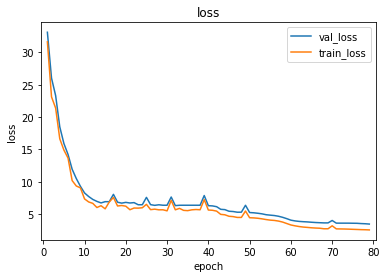

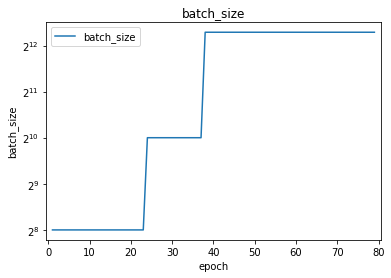

In [14]:
model.plot(['val_loss', 'train_loss'], 'loss', 'loss', scale='linear', basey=10)
model.plot(['batch_size'], 'batch_size', 'batch_size', scale='log', basey=2)

In [12]:
worst_tags = list(dict(sorted(list(model.beam_stats[1]['worst'].items()), key=lambda x: x[1], reverse=False)).keys())

In [9]:
worst_tags

dict_keys(['NN', 'JJ', 'NNP', 'RB', 'IN', 'VBN', 'NNS', 'VBD', 'VB', 'VBP', 'NNPS', 'VBG', 'JJR', 'VBZ', 'RBR', 'DT', 'RP', 'CD', 'WDT', 'JJS', 'RBS', 'POS', 'PDT', '#', 'MD', 'UH', 'FW', 'CC', 'PRP', "''", 'PRP$', '$', '.', ',', 'WP', '-LRB-', 'TO', ':', '-RRB-', 'WRB', 'EX', 'WP$', '``', 'SYM'])

In [19]:
model.beam_stats[1]['matrix'][worst_tags].loc[worst_tags].T

,NN,JJ,NNP,RB,IN,VBN,NNS,VBD,VB,VBP,...,WP,-LRB-,TO,:,-RRB-,WRB,EX,WP$,``,SYM
NN,3133,94,15,11,3,5,9,3,18,12,...,0,0,0,0,0,0,0,0,0,0
JJ,112,1299,23,22,1,28,1,1,7,6,...,0,0,0,0,0,0,0,0,0,0
NNP,26,26,1916,0,3,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
RB,3,12,1,713,52,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
IN,2,1,0,18,2479,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
VBN,0,32,0,0,0,431,0,31,0,0,...,0,0,0,0,0,0,0,0,0,0
NNS,35,2,8,1,0,0,1432,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VBD,2,8,1,0,0,33,0,791,2,6,...,0,0,0,0,0,0,0,0,0,0
VB,16,8,0,6,1,1,0,1,540,16,...,0,0,0,0,0,0,0,0,0,0
VBP,7,1,0,0,0,0,0,7,11,283,...,0,0,0,0,0,0,0,0,0,0


In [16]:
model.beam_stats[1]['worst']

{'NN': 0.9806116414632086,
 'JJ': 0.9823434991974318,
 'NNP': 0.9930725690631073,
 'RB': 0.9935372138210695,
 'IN': 0.9941285798766579,
 'VBN': 0.9943397820393681,
 'NNS': 0.9948044267973304,
 'VBD': 0.9959871589085072,
 'VB': 0.9960293993410493,
 'VBP': 0.9968319675593478,
 'NNPS': 0.9969164484244318,
 'VBG': 0.9969586888569739,
 'JJR': 0.9977190166427304,
 'VBZ': 0.9980146996705246,
 'RBR': 0.998479344428487,
 'DT': 0.9986483061586551,
 'RP': 0.9987750274562811,
 'CD': 0.9991129509166173,
 'WDT': 0.9992396722142435,
 'JJS': 0.9993663935118695,
 'RBS': 0.9995353552420376,
 'POS': 0.9996620765396638,
 'PDT': 0.9997465574047478,
 '#': 0.9997887978372898,
 'MD': 0.9997887978372898,
 'UH': 0.9998310382698319,
 'FW': 0.9998732787023739,
 'CC': 0.9998732787023739,
 'PRP': 0.9999155191349159,
 "''": 0.9999155191349159,
 'PRP$': 0.9999155191349159,
 '$': 0.9999577595674579,
 '.': 0.9999577595674579,
 ',': 1.0,
 'WP': 1.0,
 '-LRB-': 1.0,
 'TO': 1.0,
 ':': 1.0,
 '-RRB-': 1.0,
 'WRB': 1.0,
 'EX'

In [23]:
aprox_num = 1000  # max samples to aproximate score
display_all = False
beam_stats = {}

for predict_beam in [1, 2, 3]:
    beam_stats[predict_beam] = {}
    beam_stats[predict_beam]['pred_tags'] = []
    beam_stats[predict_beam]['true_tags'] = []
    pbar = tqdm(val_dataset.sentences[:aprox_num])
    for sentence in pbar:
        preds = model(sentence[0], predict_beam)
        beam_stats[predict_beam]['pred_tags'].append(preds)
        beam_stats[predict_beam]['true_tags'].append(sentence[1])

        if display_all:
            display(pd.DataFrame((sentence[0], sentence[1], preds), index=('words', 'tags', 'preds')))
        pbar.set_postfix(acc=model.score_func(beam_stats[predict_beam]['pred_tags'],
                                              beam_stats[predict_beam]['true_tags']),
                         refresh=False)

    beam_stats[predict_beam]['matrix'], beam_stats[predict_beam]['worst'] = metrics.confusion_matrix(train_dataset.tags,
                                                                                                     beam_stats[predict_beam]['pred_tags'],
                                                                                                     beam_stats[predict_beam]['true_tags'])
#     display(worst)

# model.val_predictions = pred_tags
# model.val_sentences = val_dataset.sentences
# model.save()

100%|██████████| 1000/1000 [1:25:07<00:00,  5.11s/it, acc=0.907]


In [26]:
model.beam_stats = beam_stats
model.save()

In [ ]:
display(matrix1)
display(matrix2)

In [ ]:
display(worst1)
display(worst2)

### Code that may be useful

In [ ]:
# sentences = {}
# for sentence in train_dataset.sentences:
#     sentences[len(sentence[0])] = sentence

In [ ]:
# %%time
# sample_sentence = (['Terms', 'were', "n't", 'disclosed', '.'],  # sentence words
#                    ['NNS',   'VBD',  'RB',  'VBN',       '.'])  # sentence true tags
# predict_beam = 100  # viterbi beam size

# tags, bp_pi = viterbi(model, sample_sentence[0], beam=predict_beam)
# print('sentence ', sample_sentence[0])
# print('true tags', sample_sentence[1])
# print('pred tags', tags)
# print()

In [7]:
%%time
sum_vec = np.zeros(len(feature_vector)).astype(np.float32)
sum_inds = 0
for t2, t1, w, i, t in train_dataset:
    vec = feature_vector(t2, t1, w, i, t, fmt='vec')
    sum_vec += vec
    sum_inds += (vec).sum()

df = pd.DataFrame(sum_vec, columns=['feat']).astype({'feat': int}).sort_values('feat', ascending=False)
print(sum_vec.sum())
print(sum_inds/len(train_dataset.sentences))
display(df.head(50))

3802186.0
760.4372


,feat
32871,16939
42333,16939
42378,16939
42289,16939
42423,16939
...,...
7471,1
7472,1
13388,1
7476,1


CPU times: user 28.2 s, sys: 15.6 ms, total: 28.3 s
Wall time: 28.8 s


In [13]:
display(df.loc[0:100].head(50))

,feat
0,6199
17008,6199
19968,6199
42480,6044
24990,6044
19758,6044
20012,6044
56,6044
26421,6044
42299,6044


In [15]:
feat, key = feature_vector.invert_feat(4914)  # 41453 22811
print(feat)
print(key)


FeatureGroup(tuple([w[i].lower(), t]))
('low-density', 'NN')


In [ ]:
# # test run train_dataset
# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_vec_t = feature_vector(t2, t1, w, i, t, fmt='vec')
# print('fmt=vec: {:.3f} sec'.format(time.time() - tic))

# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_list_t = feature_vector(t2, t1, w, i, t, fmt='list')
# print('fmt=list: {:.3f} sec'.format(time.time() - tic))

# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_vec_t, feat_list_t = feature_vector(t2, t1, w, i, t, fmt='both')
# print('fmt=vec+list: {:.3f} sec'.format(time.time() - tic))

In [ ]:
# for tag in train1_statistics.words_per_tag:
#     if len(train1_statistics.words_per_tag[tag]) < 10:
#         print('{:5} tf: {:5d} unique_count: {:4d} words: {}'.format(tag, train1_statistics.tags_count[tag], len(train1_statistics.words_per_tag[tag]),
#                                                                     train1_statistics.words_per_tag[tag]))
#     else:
#         print('{:5} tf: {:5d} unique_count: {:4d}'.format(tag, train1_statistics.tags_count[tag], len(train1_statistics.words_per_tag[tag])))

In [ ]:
# features = []

# # one-to-one features
# for word in strange_words:
#     features.append(Feature(f'w[i] == "{word}"', t=train1_model.tags_per_word[word][0]))
#     print(word, train1_model.WordCount[word], train1_model.TagsPerWord[word])